In [1]:
#!pip install akshare --upgrade
#!pip install keras

In [1]:
import bs4 as bs
import pickle
import requests
import scipy.optimize as sco
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import akshare as ak
import os
from tqdm import tqdm
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [2]:
def SS50Codes():
    resp = requests.get('https://q.stock.sohu.com/cn/bk_4272.shtml')
    resp.encoding = 'gb2312'
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'id': 'BIZ_MS_plstock'})
    codes = []
    for row in table.findAll('tr')[2:]:
        code = row.findAll('td')[0].text
        codes.append(code)
    return codes

def SS50Names():
    resp = requests.get('https://q.stock.sohu.com/cn/bk_4272.shtml')
    resp.encoding = 'gb2312'
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'id': 'BIZ_MS_plstock'})
    names=[]
    for row in table.findAll('tr')[2:]:
        name = row.findAll('td')[1].text
        names.append(name)
    return names
codes = SS50Codes()
names = SS50Names()
print(codes)
print(names)

['600036', '601229', '600031', '601166', '600104', '600030', '603259', '601668', '601628', '601766', '601857', '601398', '601390', '600029', '600028', '601818', '601211', '601066', '601111', '600837', '600887', '601888', '600690', '600519', '600016', '601989', '601988', '601601', '600019', '601186', '600703', '600196', '601318', '601800', '600050', '601319', '601288', '601688', '603993', '600309', '600048', '600276', '601138', '601336', '601088', '600585', '600000', '601328', '601939', '600340']
['招商银行', '上海银行', '三一重工', '兴业银行', '上汽集团', '中信证券', '药明康德', '中国建筑', '中国人寿', '中国中车', '中国石油', '工商银行', '中国中铁', '南方航空', '中国石化', '光大银行', '国泰君安', '中信建投', '中国国航', '海通证券', '伊利股份', '中国国旅', '海尔智家', '贵州茅台', '民生银行', '中国重工', '中国银行', '中国太保', '宝钢股份', '中国铁建', '三安光电', '复星医药', '中国平安', '中国交建', '中国联通', '中国人保', '农业银行', '华泰证券', '洛阳钼业', '万华化学', '保利地产', '恒瑞医药', '工业富联', '新华保险', '中国神华', '海螺水泥', '浦发银行', '交通银行', '建设银行', '华夏幸福']


In [3]:
SH50_codes = codes
SH50_codes = list(map(str,SH50_codes))
SH50_df = {}
for i in SH50_codes:
    SH50_df[i] = ak.stock_zh_a_hist(symbol=i, period='monthly', start_date="20220101", end_date='20221031', adjust="")

In [4]:
list_open = []
list_close=[]
for key in SH50_df.keys():
    list_open.append(SH50_df[key]['开盘'])
    list_close.append(SH50_df[key]['收盘'])

In [5]:
open = pd.DataFrame(list_open,index=codes)
open.rename=["codes"]
close = pd.DataFrame(list_close,index=codes)
close.rename=["codes"]
#open_df = pd.DataFrame(open)
#close_df = pd.DataFrame(close)
var = close-open

In [6]:
edge_model = covariance.GraphicalLassoCV(cv=5)
X = var.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -3.936e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

In [7]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(np.array(names)[labels == i])))
    print('Cluster %i: %s' % ((i + 1), ', '.join(np.array(codes)[labels == i])))


Cluster 1: 三一重工, 上汽集团, 中信证券, 国泰君安, 中信建投, 华泰证券
Cluster 1: 600031, 600104, 600030, 601211, 601066, 601688
Cluster 2: 中国中车, 海通证券, 中国重工, 三安光电, 中国联通, 恒瑞医药, 工业富联
Cluster 2: 601766, 600837, 601989, 600703, 600050, 600276, 601138
Cluster 3: 中国石油, 中国石化, 民生银行, 宝钢股份
Cluster 3: 601857, 600028, 600016, 600019
Cluster 4: 招商银行, 上海银行, 兴业银行, 南方航空, 中国国航, 中国平安, 浦发银行
Cluster 4: 600036, 601229, 601166, 600029, 601111, 601318, 600000
Cluster 5: 伊利股份, 中国国旅, 海尔智家, 贵州茅台, 保利地产
Cluster 5: 600887, 601888, 600690, 600519, 600048
Cluster 6: 药明康德, 复星医药, 华夏幸福
Cluster 6: 603259, 600196, 600340
Cluster 7: 中国建筑, 中国中铁, 中国铁建, 中国交建, 海螺水泥
Cluster 7: 601668, 601390, 601186, 601800, 600585
Cluster 8: 工商银行, 光大银行, 中国银行, 农业银行, 中国神华, 交通银行, 建设银行
Cluster 8: 601398, 601818, 601988, 601288, 601088, 601328, 601939
Cluster 9: 中国人寿, 中国太保, 中国人保, 洛阳钼业, 万华化学, 新华保险
Cluster 9: 601628, 601601, 601319, 603993, 600309, 601336


In [8]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

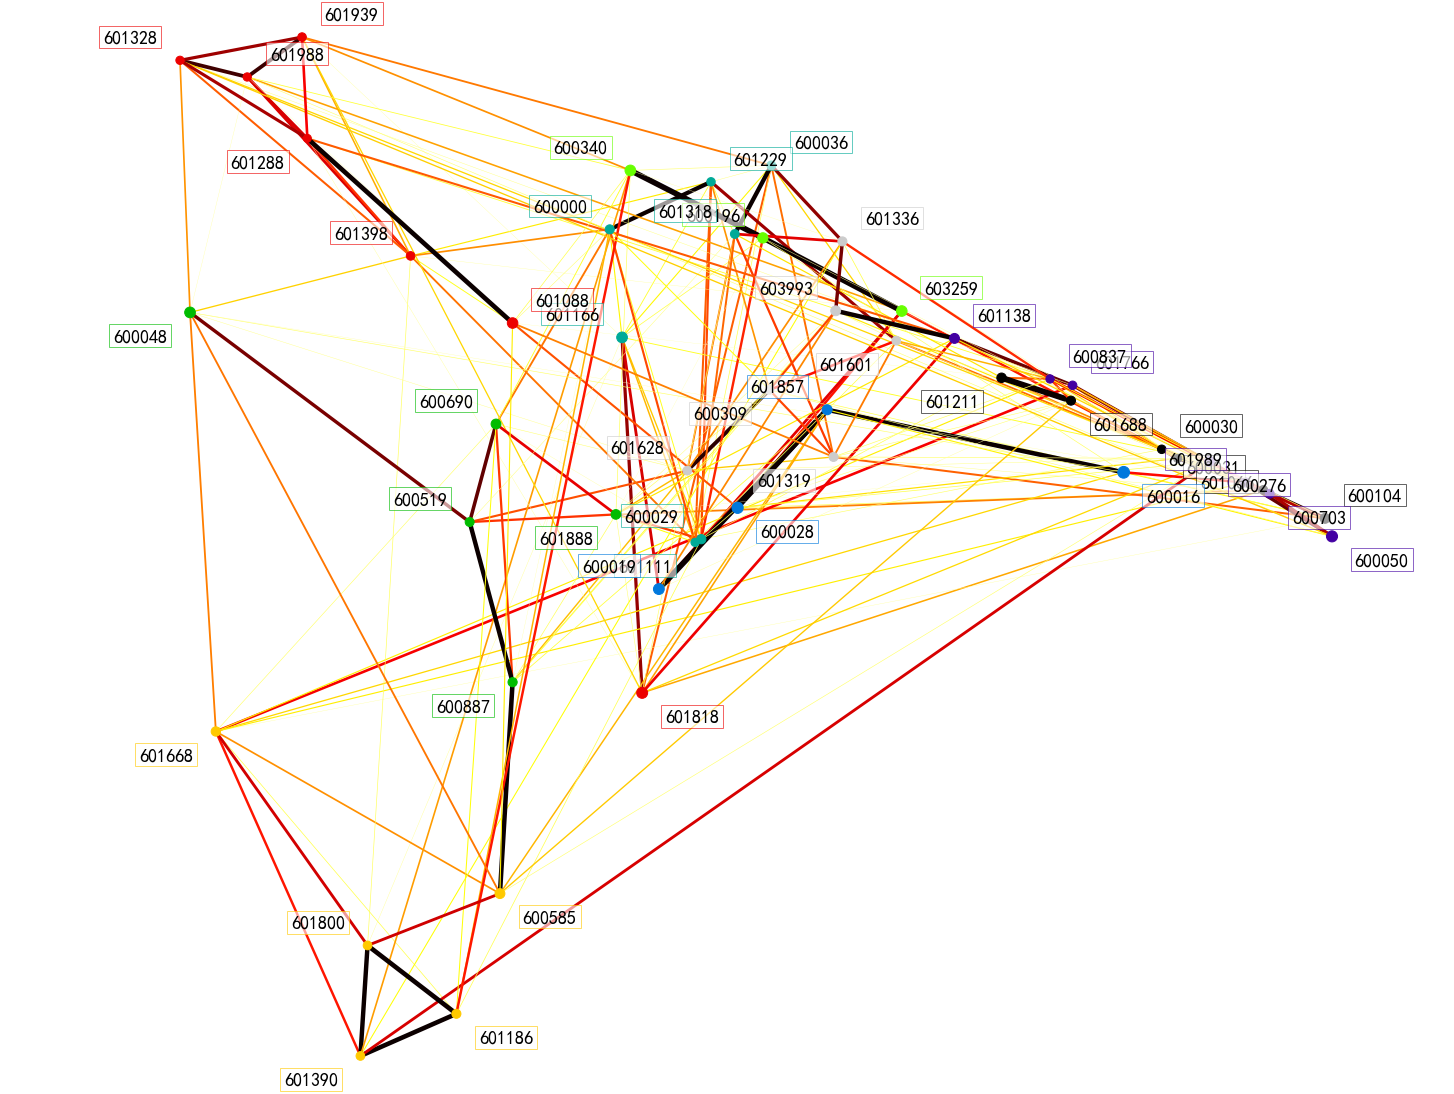

In [20]:
plt.figure(1, facecolor='w', figsize=(20, 15))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')
 
# 计算偏相关系数
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
 
# 使用嵌入的坐标绘制节点
plt.scatter(embedding[0], embedding[1], s=200 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)
 
#Draw interrelated edges
start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)
 
#向每个节点添加一个标签，难点在于定位标签，以避免与其他标签重叠
for index, (name, label, (x, y)) in enumerate(
        zip(codes, labels, embedding.T)):
 
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .01
    else:
        horizontalalignment = 'right'
        x = x - .01
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .01
    else:
        verticalalignment = 'top'
        y = y - .01
    plt.text(x, y, name, size=18,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))
 
plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())
 
plt.show()


In [10]:
Cluster1={'600031', '600104', '600030', '601211', '601066', '601688'}
Cluster2={'601766', '600837', '601989', '600703', '600050', '600276', '601138'}
Cluster3={'601857', '600028', '600016', '600019'}
Cluster4={'600036', '601229', '601166', '600029', '601111', '601318', '600000'}
Cluster5={'600887', '601888', '600690', '600519', '600048'}
Cluster6={'603259', '600196', '600340'}
Cluster7={'601668', '601390', '601186', '601800', '600585'}
Cluster8={'601398', '601818', '601988', '601288', '601088', '601328', '601939'}
Cluster9={'601628', '601601', '601319', '603993', '600309', '601336'}

In [13]:
SH50_cluster1_dic = {}
for i in Cluster1:
    SH50_cluster1_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [14]:
list_date = []
list_close=[]
for key in SH50_cluster1_dic.keys():
    SH50_cluster1_dic[key]['Date'] = SH50_cluster1_dic[key].pop('日期')
    SH50_cluster1_dic[key]['Close'] = SH50_cluster1_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 12s 313ms/step - loss: 0.0299 - val_loss: 238.2309
Epoch 2/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0086 - val_loss: 235.3252
Epoch 3/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0050 - val_loss: 236.6777
Epoch 4/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0029 - val_loss: 235.2590
Epoch 5/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0030 - val_loss: 236.1285
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0024 - val_loss: 235.4470
Epoch 7/100
10/10 [==============================] - 1s 100ms/step - loss: 0.0029 - val_loss: 235.9096
Epoch 8/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0028 - val_loss: 235.9735
Epoch 9/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0028 - val_loss: 235.1989
Epoch 10/100
10/10 [==============================] - 1s 104ms/step - loss:

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


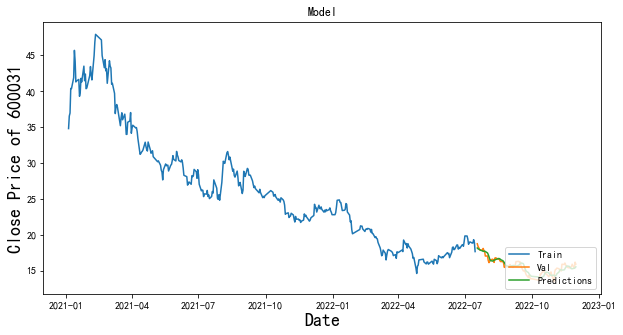

Epoch 1/100
10/10 [==============================] - 11s 271ms/step - loss: 0.0984 - val_loss: 188.4297
Epoch 2/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0294 - val_loss: 184.6147
Epoch 3/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0209 - val_loss: 188.7073
Epoch 4/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0191 - val_loss: 186.9155
Epoch 5/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0162 - val_loss: 186.8560
Epoch 6/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0186 - val_loss: 188.3880
Epoch 7/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0138 - val_loss: 188.8722
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0149 - val_loss: 188.6987
Epoch 9/100
10/10 [==============================] - 1s 77ms/step - loss: 0.0122 - val_loss: 189.0100
Epoch 10/100
10/10 [==============================] - 1s 76ms/step - loss: 0.012

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


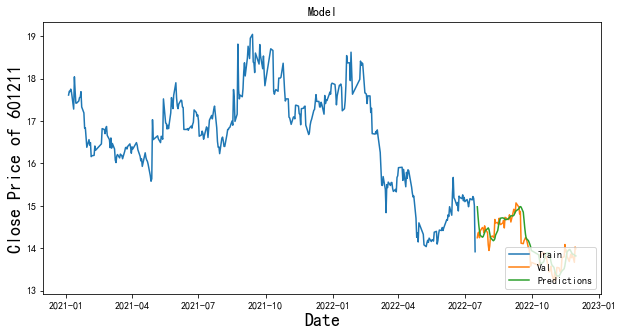

Epoch 1/100
10/10 [==============================] - 11s 332ms/step - loss: 0.1040 - val_loss: 151.8478
Epoch 2/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0276 - val_loss: 154.3228
Epoch 3/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0184 - val_loss: 154.4846
Epoch 4/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0170 - val_loss: 153.6638
Epoch 5/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0162 - val_loss: 155.2599
Epoch 6/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0144 - val_loss: 155.5250
Epoch 7/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0130 - val_loss: 155.2445
Epoch 8/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0123 - val_loss: 154.4410
Epoch 9/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0120 - val_loss: 154.9289
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 0.011

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


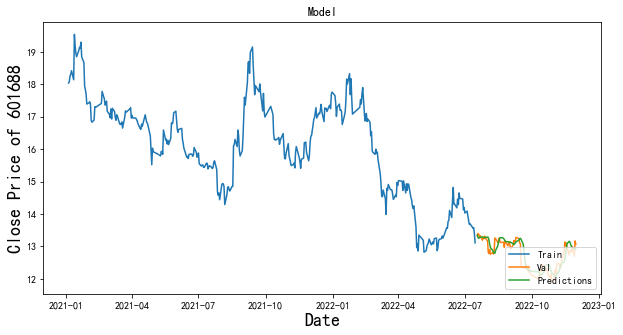

Epoch 1/100
10/10 [==============================] - 11s 263ms/step - loss: 0.0574 - val_loss: 345.3836
Epoch 2/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0143 - val_loss: 342.0400
Epoch 3/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0104 - val_loss: 345.9648
Epoch 4/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0098 - val_loss: 343.1816
Epoch 5/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0083 - val_loss: 343.9944
Epoch 6/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0080 - val_loss: 345.1068
Epoch 7/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0071 - val_loss: 344.6493
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0069 - val_loss: 344.6860
Epoch 9/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0069 - val_loss: 345.3719
Epoch 10/100
10/10 [==============================] - 1s 82ms/step - loss: 0.006

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


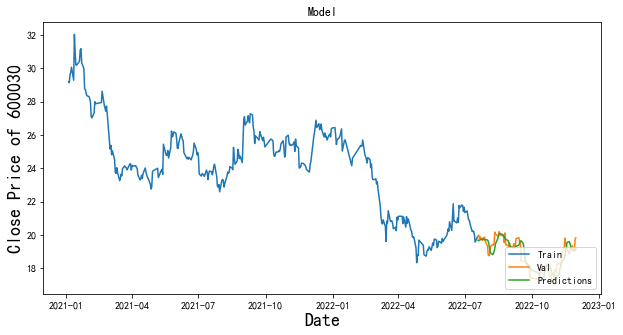

Epoch 1/100
10/10 [==============================] - 12s 311ms/step - loss: 0.0272 - val_loss: 624.7977
Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0086 - val_loss: 617.3245
Epoch 3/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0070 - val_loss: 621.1116
Epoch 4/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0067 - val_loss: 620.6457
Epoch 5/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0057 - val_loss: 618.8547
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0055 - val_loss: 617.8996
Epoch 7/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0056 - val_loss: 618.6750
Epoch 8/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0057 - val_loss: 618.6943
Epoch 9/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0048 - val_loss: 618.7680
Epoch 10/100
10/10 [==============================] - 1s 110ms/step - lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


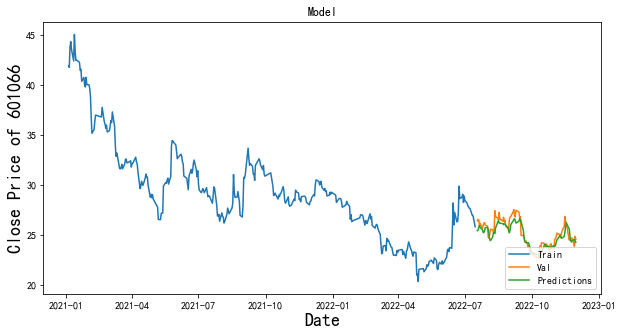

Epoch 1/100
10/10 [==============================] - 9s 234ms/step - loss: 0.0409 - val_loss: 222.4232
Epoch 2/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0152 - val_loss: 218.0425
Epoch 3/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0109 - val_loss: 220.6385
Epoch 4/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0075 - val_loss: 219.2827
Epoch 5/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0073 - val_loss: 220.6533
Epoch 6/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0072 - val_loss: 220.1952
Epoch 7/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0065 - val_loss: 220.6795
Epoch 8/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0056 - val_loss: 220.9998
Epoch 9/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0062 - val_loss: 220.0961
Epoch 10/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0060

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\752150133.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


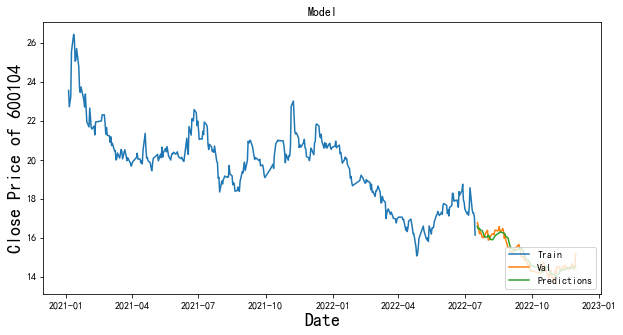

In [15]:
for i in SH50_cluster1_dic:
    data=SH50_cluster1_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#Using only the Close column, that is, using only the closing price of the stock for fitting and prediction
    dataset=data[['Close']].values
    Cluster1_list = list(SH50_cluster1_dic)

#Take 80% of the data as the training set
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#Take the remaining data as the test set
#When making a prediction, the first data of the remaining data requires data from the first 60 days to make the prediction, so this is backtracked to 60 days
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
#Reconstruction of training sets
#1. Separate x and y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
#2. Convert list type data into array data
    x_train,y_train=np.array(x_train),np.array(y_train)
#3. Transforming 2D data into 3D data
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
#Reconstruction of test sets
#1. Separate x and y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
#2. Convert list type data into array data
    x_test = np.array(x_test)
#3. Transforming 2D data into 3D data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    #Build model
    # Initialize model
    model = Sequential()
    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))
    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))
    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))
    # Add fully connected layer
    model.add(Dense(units=1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)
    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    #create dataframe
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #Add a new column to the valid and assign the predicted values' predictions' to the new column
    valid['Predictions'] = predictions
    #Start drawing
    #Image size
    plt.figure(figsize=(10,5))
    #Draw a line chart of the training set
    plt.plot(train['Close'])
   #Draw the line chart of the real value and the predicted value respectively
    plt.plot(valid[['Close', 'Predictions']])
    #Image title
    plt.title('Model')
    #x-axis
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y-axis
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #Display Legend
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [16]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 98.47%


In [17]:
# Flatten predictions array
predictions_flat = predictions.flatten()
# Calculate global variance
global_variances = np.var(predictions_flat) * (len(predictions_flat) ) / (len(predictions_flat)- 1)
print("Global Variance:", global_variances)

Global Variance: 0.6948535573351514


In [18]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions)-1):
    predicted_returns.append((predictions[i+1]/predictions[i])-1)
# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)
print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.14%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1650655201.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [19]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions, axis=0) / predictions[:-1]
# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)
# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)
print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -5.406995741677532


In [20]:
SH50_cluster2_dic = {}
for i in Cluster2:
    SH50_cluster2_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [21]:
list_date = []
list_close=[]
for key in SH50_cluster2_dic.keys():
    SH50_cluster2_dic[key]['Date'] = SH50_cluster2_dic[key].pop('日期')
    SH50_cluster2_dic[key]['Close'] = SH50_cluster2_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 11s 347ms/step - loss: 0.0426 - val_loss: 22.0361
Epoch 2/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0145 - val_loss: 20.9248
Epoch 3/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0088 - val_loss: 21.5969
Epoch 4/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0081 - val_loss: 21.1061
Epoch 5/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0065 - val_loss: 21.2674
Epoch 6/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0065 - val_loss: 21.4271
Epoch 7/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0060 - val_loss: 21.4272
Epoch 8/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0057 - val_loss: 21.2437
Epoch 9/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0057 - val_loss: 21.3612
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0059 - val_l

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


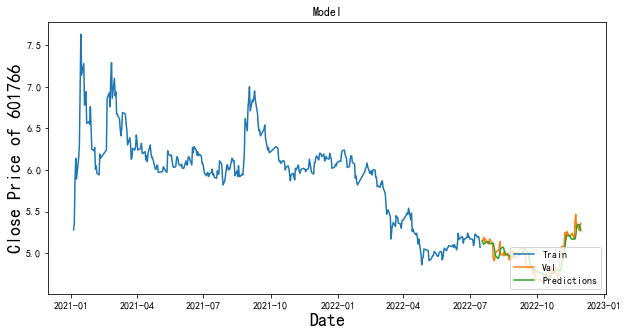

Epoch 1/100
10/10 [==============================] - 11s 327ms/step - loss: 0.0509 - val_loss: 76.0776
Epoch 2/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0119 - val_loss: 74.2404
Epoch 3/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0073 - val_loss: 74.8245
Epoch 4/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0054 - val_loss: 74.7394
Epoch 5/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0061 - val_loss: 74.8299
Epoch 6/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0055 - val_loss: 74.6849
Epoch 7/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0058 - val_loss: 74.4764
Epoch 8/100
10/10 [==============================] - 1s 130ms/step - loss: 0.0046 - val_loss: 74.6308
Epoch 9/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0041 - val_loss: 74.5180
Epoch 10/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0043 - va

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


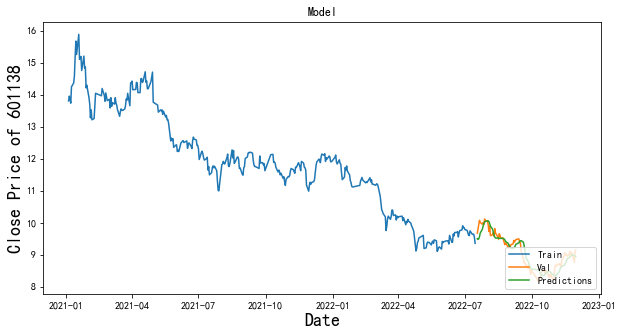

Epoch 1/100
10/10 [==============================] - 13s 324ms/step - loss: 0.0575 - val_loss: 10.9765
Epoch 2/100
10/10 [==============================] - 1s 132ms/step - loss: 0.0190 - val_loss: 10.0672
Epoch 3/100
10/10 [==============================] - 1s 134ms/step - loss: 0.0139 - val_loss: 10.6698
Epoch 4/100
10/10 [==============================] - 1s 126ms/step - loss: 0.0132 - val_loss: 10.3067
Epoch 5/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0111 - val_loss: 10.4266
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0101 - val_loss: 10.4584
Epoch 7/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0092 - val_loss: 10.1083
Epoch 8/100
10/10 [==============================] - 1s 126ms/step - loss: 0.0092 - val_loss: 10.4411
Epoch 9/100
10/10 [==============================] - 1s 139ms/step - loss: 0.0092 - val_loss: 10.0932
Epoch 10/100
10/10 [==============================] - 1s 147ms/step - loss: 0.008

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


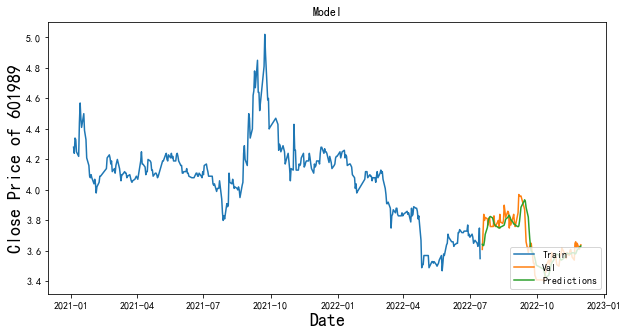

Epoch 1/100
10/10 [==============================] - 12s 317ms/step - loss: 0.1078 - val_loss: 10.9106
Epoch 2/100
10/10 [==============================] - 1s 130ms/step - loss: 0.0239 - val_loss: 10.9223
Epoch 3/100
10/10 [==============================] - 1s 132ms/step - loss: 0.0146 - val_loss: 11.2900
Epoch 4/100
10/10 [==============================] - 1s 130ms/step - loss: 0.0124 - val_loss: 11.2883
Epoch 5/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0114 - val_loss: 11.5964
Epoch 6/100
10/10 [==============================] - 1s 127ms/step - loss: 0.0082 - val_loss: 11.8077
Epoch 7/100
10/10 [==============================] - 1s 130ms/step - loss: 0.0082 - val_loss: 11.7144
Epoch 8/100
10/10 [==============================] - 1s 127ms/step - loss: 0.0086 - val_loss: 11.6525
Epoch 9/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0093 - val_loss: 11.5464
Epoch 10/100
10/10 [==============================] - 1s 134ms/step - loss: 0.007

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


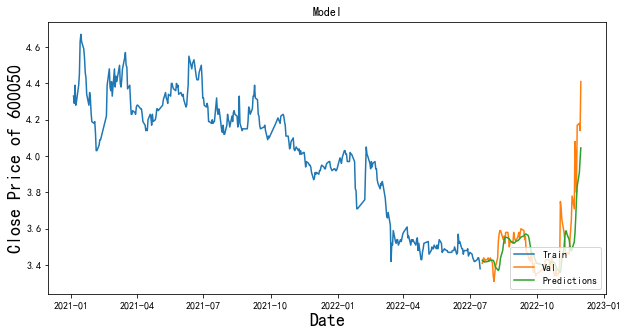

Epoch 1/100
10/10 [==============================] - 11s 312ms/step - loss: 0.0203 - val_loss: 1351.7660
Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0056 - val_loss: 1342.7030
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0038 - val_loss: 1340.0044
Epoch 4/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0028 - val_loss: 1337.6442
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0031 - val_loss: 1340.0234
Epoch 6/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0026 - val_loss: 1341.4116
Epoch 7/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0030 - val_loss: 1340.7429
Epoch 8/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0027 - val_loss: 1340.8436
Epoch 9/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0030 - val_loss: 1339.0618
Epoch 10/100
10/10 [==============================] - 1s 101ms/st

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


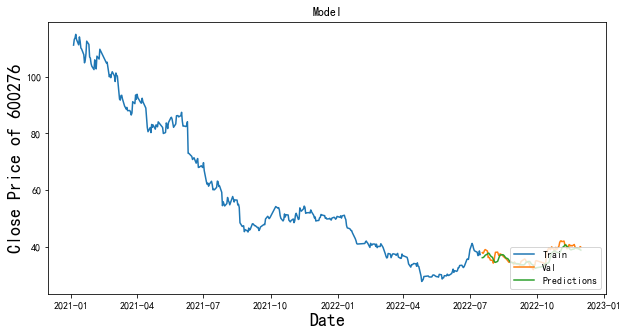

Epoch 1/100
10/10 [==============================] - 10s 256ms/step - loss: 0.0952 - val_loss: 431.6434
Epoch 2/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0201 - val_loss: 432.4613
Epoch 3/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0149 - val_loss: 434.9795
Epoch 4/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0136 - val_loss: 431.3412
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0098 - val_loss: 433.9081
Epoch 6/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0106 - val_loss: 433.0494
Epoch 7/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0099 - val_loss: 433.4945
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0098 - val_loss: 433.4047
Epoch 9/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0082 - val_loss: 432.9379
Epoch 10/100
10/10 [==============================] - 1s 91ms/step - loss: 0.008

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


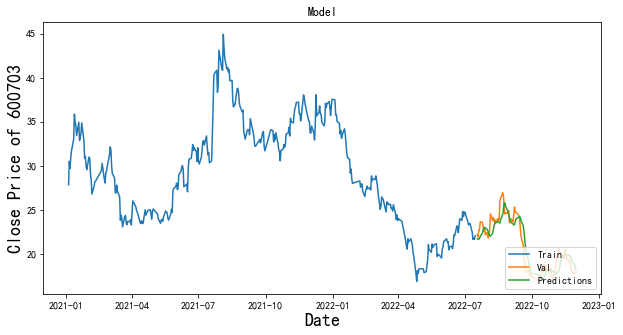

Epoch 1/100
10/10 [==============================] - 10s 270ms/step - loss: 0.0920 - val_loss: 74.7866
Epoch 2/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0243 - val_loss: 72.4562
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0174 - val_loss: 74.2018
Epoch 4/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0131 - val_loss: 73.7771
Epoch 5/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0111 - val_loss: 73.9273
Epoch 6/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0110 - val_loss: 74.4021
Epoch 7/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0095 - val_loss: 73.8535
Epoch 8/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0088 - val_loss: 74.4068
Epoch 9/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0098 - val_loss: 74.5021
Epoch 10/100
10/10 [==============================] - 1s 116ms/step - loss: 0.008

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1623450616.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions2


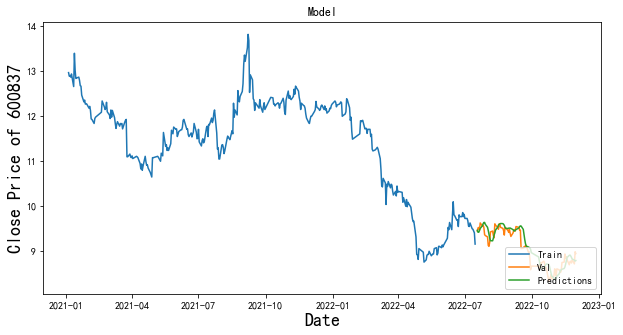

In [22]:
for i in SH50_cluster2_dic:
    data=SH50_cluster2_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#Using only the Close column, that is, using only the closing price of the stock for fitting and prediction
    dataset=data[['Close']].values
    Cluster2_list = list(SH50_cluster2_dic)

#Take 80% of the data as the training set
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#Take the remaining data as the test set
#When making a prediction, the first data of the remaining data requires data from the first 60 days to make the prediction, so this is backtracked to 60 days
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #Reconstruction of training sets
    #1. Separate x and y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 Convert list type data to array data
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 Transforming 2D data into 3D data
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

#Reconstruction of test sets
#1. Separate x and y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
#2. Convert list type data into array data
    x_test = np.array(x_test)
#3. Transforming 2D data into 3D data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model

    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions2 = model.predict(x_test)

    predictions2 = scaler.inverse_transform(predictions2)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions2
#Start drawing
#Image size
    plt.figure(figsize=(10,5))
#Image Title
    plt.plot(train['Close'])
#Draw the line chart of the real value and the predicted value respectively
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
#X-axis
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#Y-axis
#Draw a line chart of the training set
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [23]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions2)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 98.18%


In [24]:
# Flatten predictions array
predictions2_flat = predictions2.flatten()

# Calculate global variance
global_variances = np.var(predictions2_flat) * ((len(predictions2_flat) )/( len(predictions2_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 0.173905482003977


In [25]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions2)-1):
    predicted_returns.append((predictions2[i+1]/predictions2[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.08%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2765889646.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [26]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions2, axis=0) / predictions2[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -2.481497245733611


In [27]:
SH50_cluster3_dic = {}
for i in Cluster3:
    SH50_cluster3_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [28]:
list_date = []
list_close=[]
for key in SH50_cluster3_dic.keys():
    SH50_cluster3_dic[key]['Date'] = SH50_cluster3_dic[key].pop('日期')
    SH50_cluster3_dic[key]['Close'] = SH50_cluster3_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 11s 280ms/step - loss: 0.0327 - val_loss: 10.3252
Epoch 2/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0102 - val_loss: 9.6279
Epoch 3/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0061 - val_loss: 10.2311
Epoch 4/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0041 - val_loss: 9.9050
Epoch 5/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0040 - val_loss: 10.0252
Epoch 6/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0039 - val_loss: 10.0135
Epoch 7/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0038 - val_loss: 10.0932
Epoch 8/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0038 - val_loss: 9.9646
Epoch 9/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0036 - val_loss: 10.1221
Epoch 10/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0037 - val_loss

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\3810561057.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions3


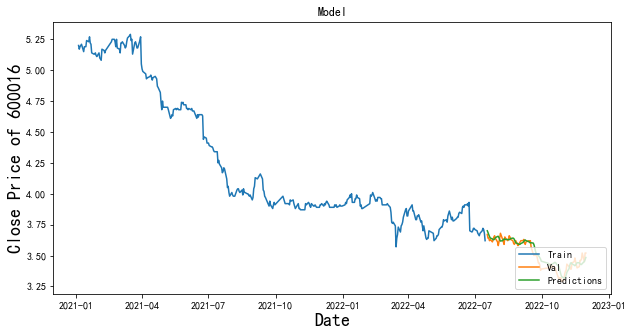

Epoch 1/100
10/10 [==============================] - 11s 271ms/step - loss: 0.0698 - val_loss: 23.9399
Epoch 2/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0250 - val_loss: 23.3140
Epoch 3/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0213 - val_loss: 23.3110
Epoch 4/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0163 - val_loss: 23.8601
Epoch 5/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0148 - val_loss: 23.6514
Epoch 6/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0133 - val_loss: 23.9821
Epoch 7/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0120 - val_loss: 24.0732
Epoch 8/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0124 - val_loss: 23.8229
Epoch 9/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0113 - val_loss: 23.8643
Epoch 10/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0110 - val_l

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\3810561057.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions3


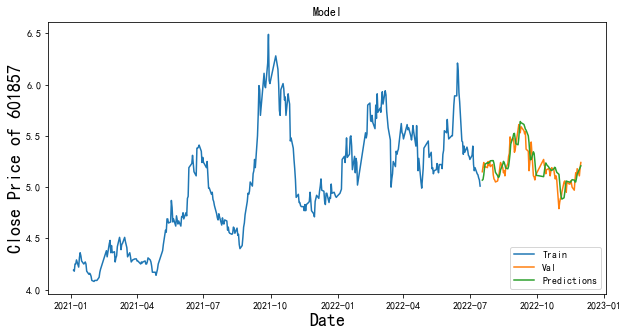

Epoch 1/100
10/10 [==============================] - 11s 296ms/step - loss: 0.0341 - val_loss: 26.6631
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0195 - val_loss: 25.2033
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0146 - val_loss: 26.1555
Epoch 4/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0119 - val_loss: 26.0375
Epoch 5/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0099 - val_loss: 26.3463
Epoch 6/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0091 - val_loss: 25.9265
Epoch 7/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0081 - val_loss: 25.8652
Epoch 8/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0076 - val_loss: 26.1310
Epoch 9/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0062 - val_loss: 26.5702
Epoch 10/100
10/10 [==============================] - 1s 103ms/step - loss: 0.006

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\3810561057.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions3


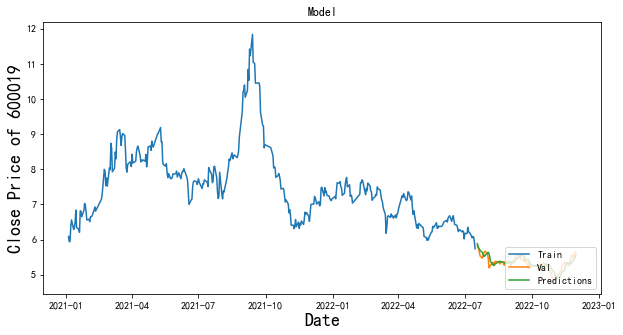

Epoch 1/100
10/10 [==============================] - 11s 291ms/step - loss: 0.0972 - val_loss: 15.3094
Epoch 2/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0457 - val_loss: 14.9804
Epoch 3/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0362 - val_loss: 14.9759
Epoch 4/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0333 - val_loss: 14.8319
Epoch 5/100
10/10 [==============================] - 1s 119ms/step - loss: 0.0285 - val_loss: 14.6962
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0262 - val_loss: 14.8609
Epoch 7/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0235 - val_loss: 14.6201
Epoch 8/100
10/10 [==============================] - 1s 122ms/step - loss: 0.0214 - val_loss: 14.4843
Epoch 9/100
10/10 [==============================] - 1s 131ms/step - loss: 0.0215 - val_loss: 14.5121
Epoch 10/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0200

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\3810561057.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions3


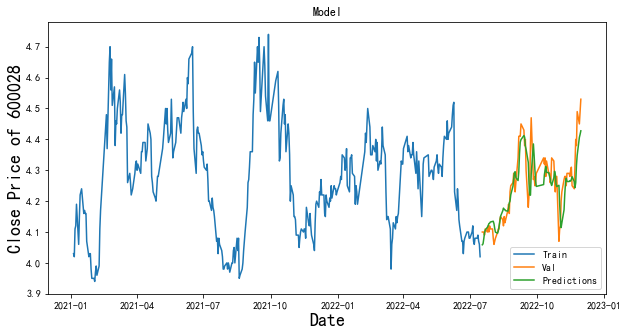

In [29]:
for i in SH50_cluster3_dic:
    data=SH50_cluster3_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster3_list = list(SH50_cluster3_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions3 = model.predict(x_test)

    predictions3 = scaler.inverse_transform(predictions3)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions3
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [30]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions3)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 98.56%


In [31]:
# Flatten predictions array
predictions3_flat = predictions3.flatten()

# Calculate global variance
global_variances = np.var(predictions3_flat) * ((len(predictions3_flat) )/( len(predictions3_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 0.008579347732957902


In [32]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions3)-1):
    predicted_returns.append((predictions3[i+1]/predictions3[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: 0.10%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\3666578209.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [33]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions3, axis=0) / predictions3[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  2.483313702437542


In [34]:
SH50_cluster4_dic = {}
for i in Cluster4:
    SH50_cluster4_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [35]:
list_date = []
list_close=[]
for key in SH50_cluster4_dic.keys():
    SH50_cluster4_dic[key]['Date'] = SH50_cluster4_dic[key].pop('日期')
    SH50_cluster4_dic[key]['Close'] = SH50_cluster4_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 11s 282ms/step - loss: 0.0865 - val_loss: 38.1528
Epoch 2/100
10/10 [==============================] - 1s 100ms/step - loss: 0.0237 - val_loss: 37.4848
Epoch 3/100
10/10 [==============================] - 1s 100ms/step - loss: 0.0200 - val_loss: 38.1839
Epoch 4/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0205 - val_loss: 38.2468
Epoch 5/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0189 - val_loss: 38.0635
Epoch 6/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0162 - val_loss: 37.9410
Epoch 7/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0161 - val_loss: 37.5174
Epoch 8/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0147 - val_loss: 37.9823
Epoch 9/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0148 - val_loss: 37.5390
Epoch 10/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0142 - val

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


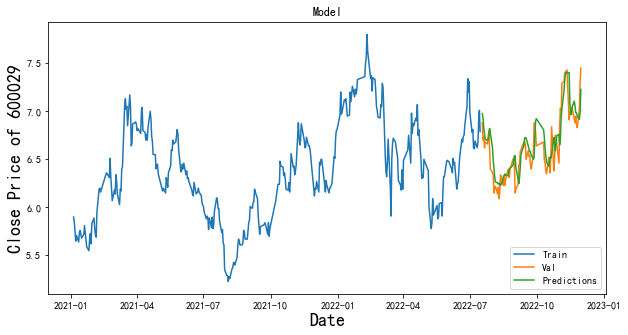

Epoch 1/100
10/10 [==============================] - 10s 262ms/step - loss: 0.0536 - val_loss: 46.4790
Epoch 2/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0154 - val_loss: 44.4596
Epoch 3/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0064 - val_loss: 46.1030
Epoch 4/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0073 - val_loss: 45.9286
Epoch 5/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0055 - val_loss: 45.4290
Epoch 6/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0045 - val_loss: 45.6901
Epoch 7/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0047 - val_loss: 45.7199
Epoch 8/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0043 - val_loss: 45.7919
Epoch 9/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0059 - val_loss: 45.6417
Epoch 10/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0065 - val_l

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


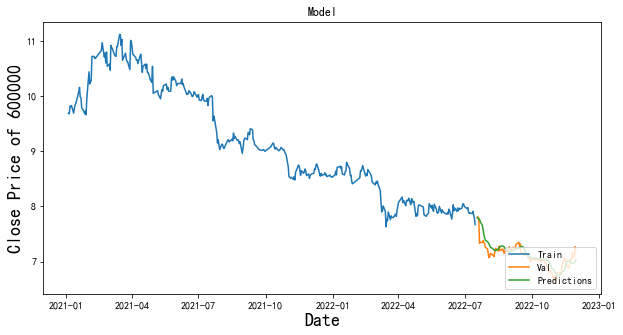

Epoch 1/100
10/10 [==============================] - 12s 307ms/step - loss: 0.1111 - val_loss: 1054.5742
Epoch 2/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0277 - val_loss: 1046.8862
Epoch 3/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0206 - val_loss: 1052.7047
Epoch 4/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0185 - val_loss: 1052.2844
Epoch 5/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0158 - val_loss: 1051.5244
Epoch 6/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0133 - val_loss: 1052.9404
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0146 - val_loss: 1054.4188
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0134 - val_loss: 1054.7380
Epoch 9/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0127 - val_loss: 1053.8824
Epoch 10/100
10/10 [==============================] - 1s 102ms/

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


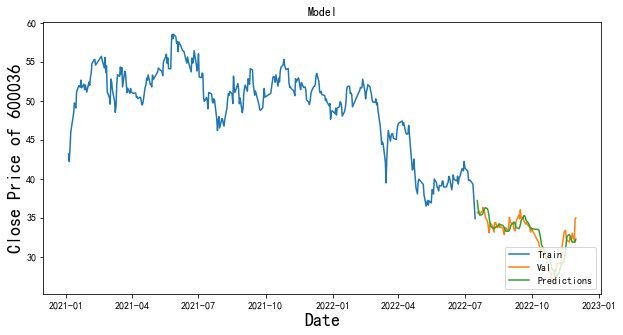

Epoch 1/100
10/10 [==============================] - 7s 249ms/step - loss: 0.0653 - val_loss: 31.2993
Epoch 2/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0157 - val_loss: 29.9999
Epoch 3/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0110 - val_loss: 31.1281
Epoch 4/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0093 - val_loss: 31.0943
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0090 - val_loss: 30.9386
Epoch 6/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0085 - val_loss: 30.9407
Epoch 7/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0087 - val_loss: 31.3112
Epoch 8/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0075 - val_loss: 31.3688
Epoch 9/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0079 - val_loss: 31.4439
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0072 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


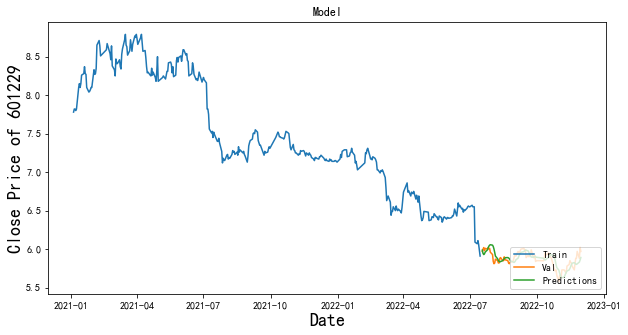

Epoch 1/100
10/10 [==============================] - 8s 227ms/step - loss: 0.0262 - val_loss: 277.2511
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0129 - val_loss: 273.0261
Epoch 3/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0110 - val_loss: 276.1081
Epoch 4/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0094 - val_loss: 274.3071
Epoch 5/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0088 - val_loss: 274.7969
Epoch 6/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0082 - val_loss: 276.0929
Epoch 7/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0088 - val_loss: 274.4561
Epoch 8/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0078 - val_loss: 275.2165
Epoch 9/100
10/10 [==============================] - 1s 96ms/step - loss: 0.0074 - val_loss: 274.1949
Epoch 10/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


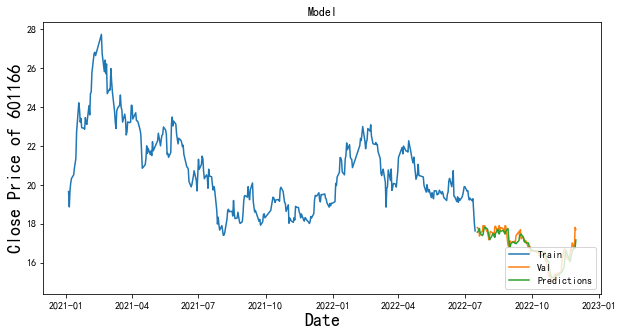

Epoch 1/100
10/10 [==============================] - 8s 219ms/step - loss: 0.0285 - val_loss: 1707.5472
Epoch 2/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0047 - val_loss: 1701.6666
Epoch 3/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0041 - val_loss: 1697.1332
Epoch 4/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0044 - val_loss: 1697.7513
Epoch 5/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0031 - val_loss: 1701.4572
Epoch 6/100
10/10 [==============================] - 1s 95ms/step - loss: 0.0032 - val_loss: 1700.5513
Epoch 7/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0033 - val_loss: 1698.3369
Epoch 8/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0030 - val_loss: 1698.2709
Epoch 9/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0031 - val_loss: 1698.8903
Epoch 10/100
10/10 [==============================] - 1s 91ms/step - l

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


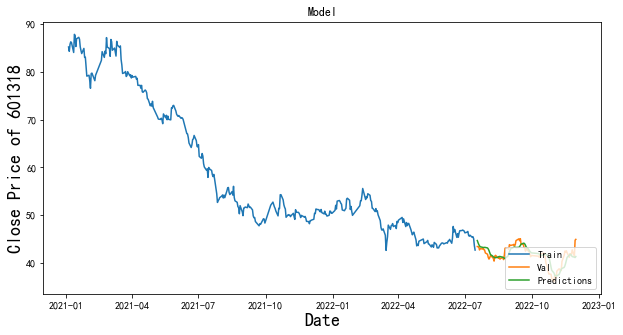

Epoch 1/100
10/10 [==============================] - 8s 206ms/step - loss: 0.0870 - val_loss: 94.1298
Epoch 2/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0257 - val_loss: 92.0395
Epoch 3/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0171 - val_loss: 93.6421
Epoch 4/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0160 - val_loss: 91.6781
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0150 - val_loss: 93.3327
Epoch 6/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0130 - val_loss: 92.2366
Epoch 7/100
10/10 [==============================] - 1s 77ms/step - loss: 0.0124 - val_loss: 92.7146
Epoch 8/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0107 - val_loss: 91.9073
Epoch 9/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0130 - val_loss: 91.6888
Epoch 10/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0122 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1682984407.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions4


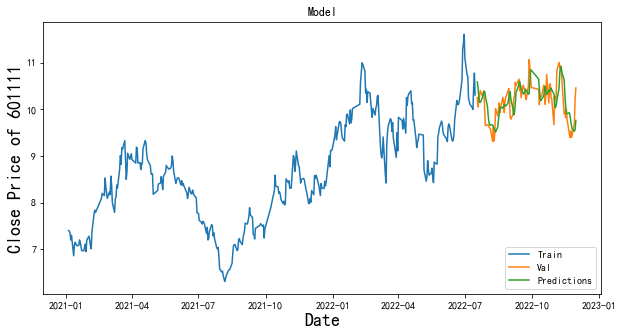

In [36]:
for i in SH50_cluster4_dic:
    data=SH50_cluster4_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster4_list = list(SH50_cluster4_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions4 = model.predict(x_test)

    predictions4 = scaler.inverse_transform(predictions4)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions4
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [37]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions4)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 97.04%


In [38]:
# Flatten predictions array
predictions4_flat = predictions4.flatten()

# Calculate global variance
global_variances = np.var(predictions4_flat) * (len(predictions4_flat) )/( len(predictions4_flat)- 1)

print("Global Variance:", global_variances)

Global Variance: 0.1180166611959646


In [39]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions4)-1):
    predicted_returns.append((predictions4[i+1]/predictions4[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.08%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2949262584.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [40]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions4, axis=0) / predictions4[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -1.0649590679042187


In [11]:
SH50_cluster5_dic = {}
for i in Cluster5:
    SH50_cluster5_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [12]:
list_date = []
list_close=[]
for key in SH50_cluster5_dic.keys():
    SH50_cluster5_dic[key]['Date'] = SH50_cluster5_dic[key].pop('日期')
    SH50_cluster5_dic[key]['Close'] = SH50_cluster5_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 7s 193ms/step - loss: 0.0808 - val_loss: 566.8713
Epoch 2/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0297 - val_loss: 564.4388
Epoch 3/100
10/10 [==============================] - 1s 54ms/step - loss: 0.0172 - val_loss: 565.4009
Epoch 4/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0168 - val_loss: 564.5711
Epoch 5/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0140 - val_loss: 564.8380
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0131 - val_loss: 563.6436
Epoch 7/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0110 - val_loss: 565.4742
Epoch 8/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0122 - val_loss: 563.0019
Epoch 9/100
10/10 [==============================] - 1s 55ms/step - loss: 0.0107 - val_loss: 562.8534
Epoch 10/100
10/10 [==============================] - 1s 57ms/step - loss: 0.0111

C:\Users\93058\AppData\Local\Temp\ipykernel_3268\3848418306.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions5


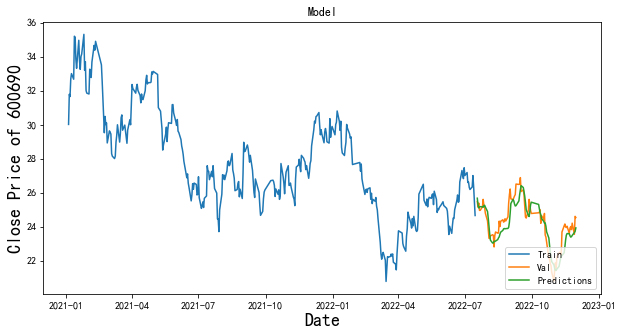

Epoch 1/100
10/10 [==============================] - 7s 188ms/step - loss: 0.0980 - val_loss: 255.1531
Epoch 2/100
10/10 [==============================] - 1s 57ms/step - loss: 0.0269 - val_loss: 252.7675
Epoch 3/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0179 - val_loss: 254.9508
Epoch 4/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0157 - val_loss: 252.7577
Epoch 5/100
10/10 [==============================] - 1s 60ms/step - loss: 0.0111 - val_loss: 253.5611
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0105 - val_loss: 253.4262
Epoch 7/100
10/10 [==============================] - 1s 59ms/step - loss: 0.0096 - val_loss: 252.3663
Epoch 8/100
10/10 [==============================] - 1s 54ms/step - loss: 0.0105 - val_loss: 253.7512
Epoch 9/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0104 - val_loss: 253.5698
Epoch 10/100
10/10 [==============================] - 1s 61ms/step - loss: 0.0101

C:\Users\93058\AppData\Local\Temp\ipykernel_3268\3848418306.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions5


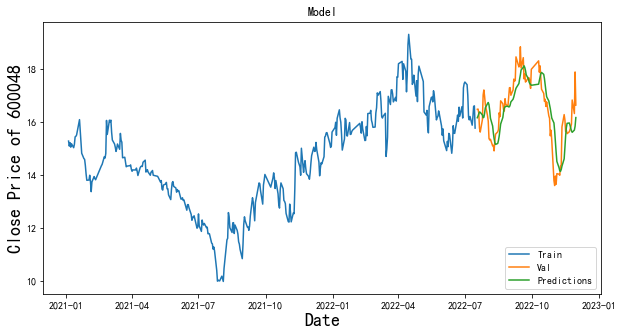

Epoch 1/100
10/10 [==============================] - 7s 213ms/step - loss: 0.0462 - val_loss: 3102147.2500
Epoch 2/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0160 - val_loss: 3101700.7500
Epoch 3/100
10/10 [==============================] - 1s 64ms/step - loss: 0.0128 - val_loss: 3102041.0000
Epoch 4/100
10/10 [==============================] - 1s 62ms/step - loss: 0.0092 - val_loss: 3101727.2500
Epoch 5/100
10/10 [==============================] - 1s 60ms/step - loss: 0.0081 - val_loss: 3101813.2500
Epoch 6/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0080 - val_loss: 3101759.7500
Epoch 7/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0078 - val_loss: 3101617.0000
Epoch 8/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0074 - val_loss: 3101541.5000
Epoch 9/100
10/10 [==============================] - 1s 62ms/step - loss: 0.0070 - val_loss: 3101776.0000
Epoch 10/100
10/10 [=========================

C:\Users\93058\AppData\Local\Temp\ipykernel_3268\3848418306.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions5


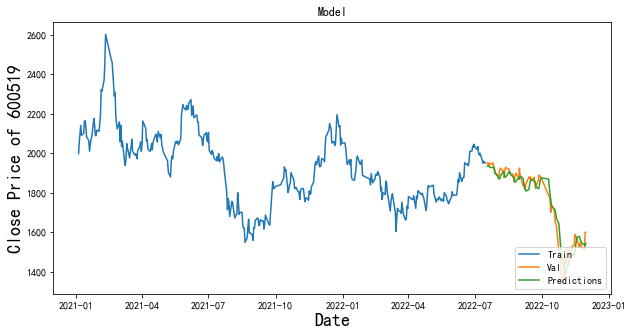

Epoch 1/100
10/10 [==============================] - 7s 193ms/step - loss: 0.0391 - val_loss: 36577.7188
Epoch 2/100
10/10 [==============================] - 1s 71ms/step - loss: 0.0136 - val_loss: 36516.1016
Epoch 3/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0087 - val_loss: 36535.8398
Epoch 4/100
10/10 [==============================] - 1s 67ms/step - loss: 0.0079 - val_loss: 36546.5234
Epoch 5/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0061 - val_loss: 36535.1211
Epoch 6/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0071 - val_loss: 36512.6562
Epoch 7/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0073 - val_loss: 36531.2500
Epoch 8/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0060 - val_loss: 36543.1484
Epoch 9/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0058 - val_loss: 36541.5547
Epoch 10/100
10/10 [==============================] - 1s 67ms/s

C:\Users\93058\AppData\Local\Temp\ipykernel_3268\3848418306.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions5


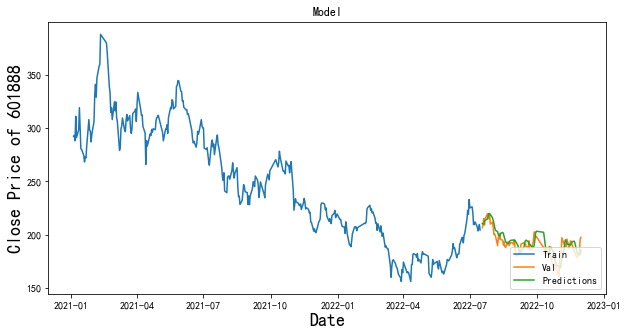

Epoch 1/100
10/10 [==============================] - 8s 198ms/step - loss: 0.0340 - val_loss: 1046.8656
Epoch 2/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0113 - val_loss: 1035.7161
Epoch 3/100
10/10 [==============================] - 1s 64ms/step - loss: 0.0086 - val_loss: 1041.8033
Epoch 4/100
10/10 [==============================] - 1s 76ms/step - loss: 0.0073 - val_loss: 1039.7327
Epoch 5/100
10/10 [==============================] - 1s 76ms/step - loss: 0.0071 - val_loss: 1037.0172
Epoch 6/100
10/10 [==============================] - 1s 74ms/step - loss: 0.0063 - val_loss: 1038.1749
Epoch 7/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0061 - val_loss: 1036.9757
Epoch 8/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0061 - val_loss: 1039.1365
Epoch 9/100
10/10 [==============================] - 1s 67ms/step - loss: 0.0067 - val_loss: 1039.7874
Epoch 10/100
10/10 [==============================] - 1s 69ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_3268\3848418306.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions5


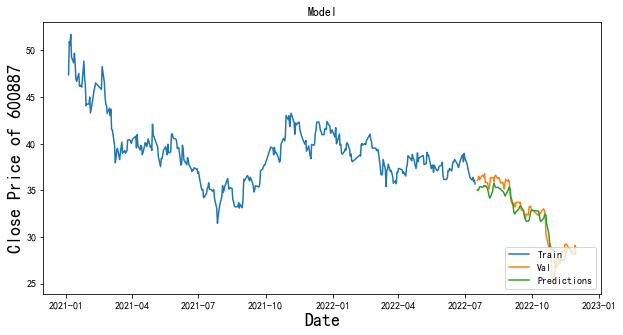

In [13]:
for i in SH50_cluster5_dic:
    data=SH50_cluster5_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster5_list = list(SH50_cluster5_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions5 = model.predict(x_test)

    predictions5 = scaler.inverse_transform(predictions5)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions5
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [14]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions5)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 97.02%


In [15]:
# Flatten predictions array
predictions5_flat = predictions5.flatten()

# Calculate global variance
global_variances = np.var(predictions5_flat) * ((len(predictions5_flat) )/( len(predictions5_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 8.51188253046392


In [16]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions5)-1):
    predicted_returns.append((predictions5[i+1]/predictions5[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.22%


C:\Users\93058\AppData\Local\Temp\ipykernel_3268\640873882.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [17]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions5, axis=0) / predictions5[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -3.254255396884168


In [48]:
SH50_cluster6_dic = {}
for i in Cluster6:
    SH50_cluster6_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [49]:
list_date = []
list_close=[]
for key in SH50_cluster6_dic.keys():
    SH50_cluster6_dic[key]['Date'] = SH50_cluster6_dic[key].pop('日期')
    SH50_cluster6_dic[key]['Close'] = SH50_cluster6_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 7s 228ms/step - loss: 0.0402 - val_loss: 1395.7533
Epoch 2/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0207 - val_loss: 1383.0409
Epoch 3/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0146 - val_loss: 1390.2924
Epoch 4/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0142 - val_loss: 1388.9530
Epoch 5/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0118 - val_loss: 1387.9543
Epoch 6/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0110 - val_loss: 1387.6262
Epoch 7/100
10/10 [==============================] - 1s 76ms/step - loss: 0.0103 - val_loss: 1387.2496
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0106 - val_loss: 1384.3430
Epoch 9/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0120 - val_loss: 1383.2617
Epoch 10/100
10/10 [==============================] - 1s 83ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\4093760390.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions6


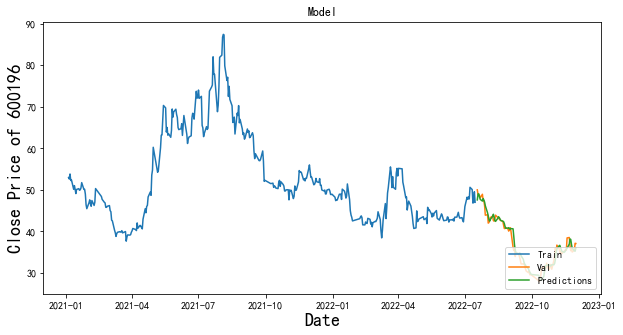

Epoch 1/100
10/10 [==============================] - 7s 207ms/step - loss: 0.1001 - val_loss: 7149.8188
Epoch 2/100
10/10 [==============================] - 1s 76ms/step - loss: 0.0269 - val_loss: 7144.1133
Epoch 3/100
10/10 [==============================] - 1s 73ms/step - loss: 0.0172 - val_loss: 7150.2373
Epoch 4/100
10/10 [==============================] - 1s 78ms/step - loss: 0.0162 - val_loss: 7145.1372
Epoch 5/100
10/10 [==============================] - 1s 77ms/step - loss: 0.0142 - val_loss: 7153.3843
Epoch 6/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0136 - val_loss: 7145.2407
Epoch 7/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0123 - val_loss: 7144.4536
Epoch 8/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0127 - val_loss: 7151.4727
Epoch 9/100
10/10 [==============================] - 1s 80ms/step - loss: 0.0124 - val_loss: 7156.3247
Epoch 10/100
10/10 [==============================] - 1s 80ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\4093760390.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions6


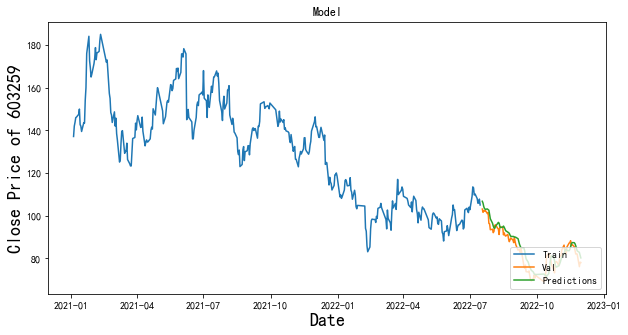

Epoch 1/100
10/10 [==============================] - 7s 204ms/step - loss: 0.0086 - val_loss: 6.3727
Epoch 2/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0032 - val_loss: 5.7489
Epoch 3/100
10/10 [==============================] - 1s 78ms/step - loss: 0.0019 - val_loss: 5.9185
Epoch 4/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0015 - val_loss: 5.9253
Epoch 5/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0016 - val_loss: 5.7972
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0013 - val_loss: 5.8828
Epoch 7/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0012 - val_loss: 5.9242
Epoch 8/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0013 - val_loss: 5.7190
Epoch 9/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0013 - val_loss: 5.8237
Epoch 10/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0012 - val_loss: 5.858

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\4093760390.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions6


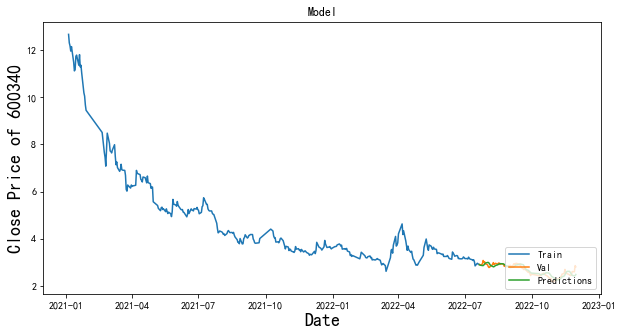

In [50]:
for i in SH50_cluster6_dic:
    data=SH50_cluster6_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster6_list = list(SH50_cluster6_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions6 = model.predict(x_test)

    predictions6 = scaler.inverse_transform(predictions6)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions6
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [51]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions6)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 95.73%


In [52]:
# Flatten predictions array
predictions6_flat = predictions6.flatten()

# Calculate global variance
global_variances = np.var(predictions6_flat) * ((len(predictions6_flat) )/( len(predictions6_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 0.04938455738804558


In [53]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions6)-1):
    predicted_returns.append((predictions6[i+1]/predictions6[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.17%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\4228171264.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [54]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions6, axis=0) / predictions6[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -2.3602220898915043


In [55]:
SH50_cluster7_dic = {}
for i in Cluster7:
    SH50_cluster7_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [56]:
list_date = []
list_close=[]
for key in SH50_cluster7_dic.keys():
    SH50_cluster7_dic[key]['Date'] = SH50_cluster7_dic[key].pop('日期')
    SH50_cluster7_dic[key]['Close'] = SH50_cluster7_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 7s 203ms/step - loss: 0.0720 - val_loss: 49.5303
Epoch 2/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0372 - val_loss: 48.6987
Epoch 3/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0318 - val_loss: 49.6058
Epoch 4/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0283 - val_loss: 49.1426
Epoch 5/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0240 - val_loss: 49.5849
Epoch 6/100
10/10 [==============================] - 1s 78ms/step - loss: 0.0213 - val_loss: 49.8979
Epoch 7/100
10/10 [==============================] - 1s 79ms/step - loss: 0.0209 - val_loss: 49.5019
Epoch 8/100
10/10 [==============================] - 1s 81ms/step - loss: 0.0198 - val_loss: 49.5705
Epoch 9/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0189 - val_loss: 49.2590
Epoch 10/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0179 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1758124044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions7


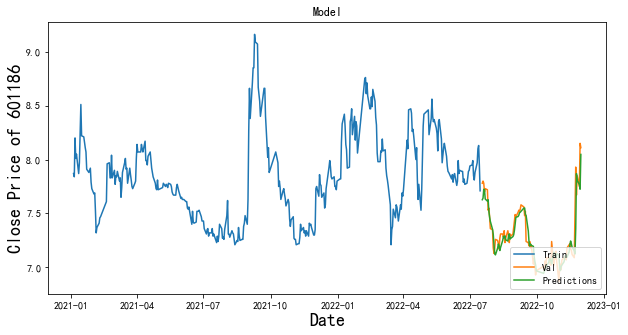

Epoch 1/100
10/10 [==============================] - 7s 205ms/step - loss: 0.0903 - val_loss: 27.6612
Epoch 2/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0322 - val_loss: 26.9749
Epoch 3/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0242 - val_loss: 27.4330
Epoch 4/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0196 - val_loss: 27.8521
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0208 - val_loss: 27.5744
Epoch 6/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0177 - val_loss: 27.5665
Epoch 7/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0179 - val_loss: 27.7899
Epoch 8/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0150 - val_loss: 27.8311
Epoch 9/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0143 - val_loss: 27.9201
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0154 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1758124044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions7


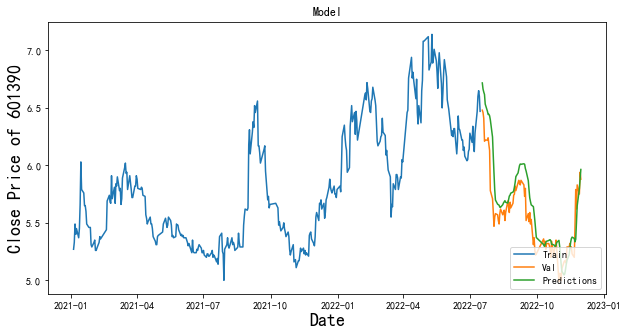

Epoch 1/100
10/10 [==============================] - 7s 252ms/step - loss: 0.0701 - val_loss: 23.6226
Epoch 2/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0220 - val_loss: 22.9936
Epoch 3/100
10/10 [==============================] - 1s 100ms/step - loss: 0.0181 - val_loss: 23.9279
Epoch 4/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0159 - val_loss: 23.3299
Epoch 5/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0140 - val_loss: 23.8776
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0126 - val_loss: 23.6587
Epoch 7/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0121 - val_loss: 23.5965
Epoch 8/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0111 - val_loss: 23.8637
Epoch 9/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0118 - val_loss: 24.0015
Epoch 10/100
10/10 [==============================] - 1s 97ms/step - loss: 0.0116 

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1758124044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions7


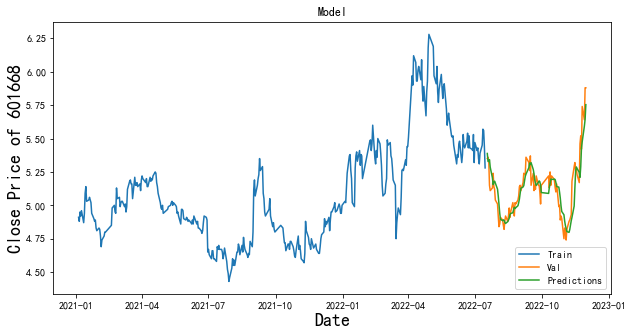

Epoch 1/100
10/10 [==============================] - 7s 201ms/step - loss: 0.0737 - val_loss: 56.2694
Epoch 2/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0343 - val_loss: 54.0429
Epoch 3/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0253 - val_loss: 55.4153
Epoch 4/100
10/10 [==============================] - 1s 92ms/step - loss: 0.0196 - val_loss: 55.4531
Epoch 5/100
10/10 [==============================] - 1s 89ms/step - loss: 0.0173 - val_loss: 55.4390
Epoch 6/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0164 - val_loss: 55.7346
Epoch 7/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0156 - val_loss: 55.7936
Epoch 8/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0153 - val_loss: 55.9200
Epoch 9/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0144 - val_loss: 55.7268
Epoch 10/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0142 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1758124044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions7


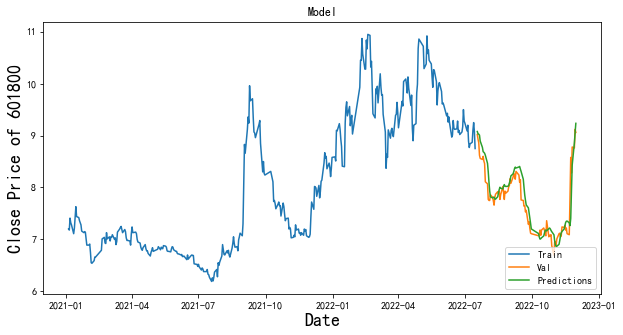

Epoch 1/100
10/10 [==============================] - 7s 202ms/step - loss: 0.0562 - val_loss: 872.7797
Epoch 2/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0182 - val_loss: 872.8027
Epoch 3/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0156 - val_loss: 875.1837
Epoch 4/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0119 - val_loss: 870.9299
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0106 - val_loss: 873.4742
Epoch 6/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0096 - val_loss: 873.1778
Epoch 7/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0089 - val_loss: 874.8192
Epoch 8/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0082 - val_loss: 873.5262
Epoch 9/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0082 - val_loss: 872.8565
Epoch 10/100
10/10 [==============================] - 1s 82ms/step - loss: 0.0088

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1758124044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions7


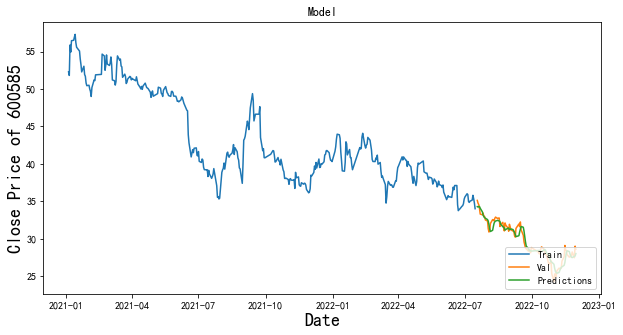

In [57]:
for i in SH50_cluster7_dic:
    data=SH50_cluster7_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster7_list = list(SH50_cluster7_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions7 = model.predict(x_test)

    predictions7 = scaler.inverse_transform(predictions7)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions7
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [58]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions7)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 97.57%


In [59]:
# Flatten predictions array
predictions7_flat = predictions7.flatten()

# Calculate global variance
global_variances = np.var(predictions7_flat) * ((len(predictions7_flat) )/( len(predictions7_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 6.065639516809484


In [60]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions7)-1):
    predicted_returns.append((predictions7[i+1]/predictions7[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.22%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\682044936.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [61]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions7, axis=0) / predictions7[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -3.616708172881265


In [62]:
SH50_cluster8_dic = {}
for i in Cluster8:
    SH50_cluster8_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [63]:
list_date = []
list_close=[]
for key in SH50_cluster8_dic.keys():
    SH50_cluster8_dic[key]['Date'] = SH50_cluster8_dic[key].pop('日期')
    SH50_cluster8_dic[key]['Close'] = SH50_cluster8_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 7s 216ms/step - loss: 0.0485 - val_loss: 16.2159
Epoch 2/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0166 - val_loss: 14.8920
Epoch 3/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0125 - val_loss: 15.8556
Epoch 4/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0103 - val_loss: 15.3526
Epoch 5/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0090 - val_loss: 15.7698
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0086 - val_loss: 15.9134
Epoch 7/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0078 - val_loss: 15.6529
Epoch 8/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0091 - val_loss: 15.3942
Epoch 9/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0086 - val_loss: 15.9333
Epoch 10/100
10/10 [==============================] - 1s 99ms/step - loss: 0.0082 - 

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


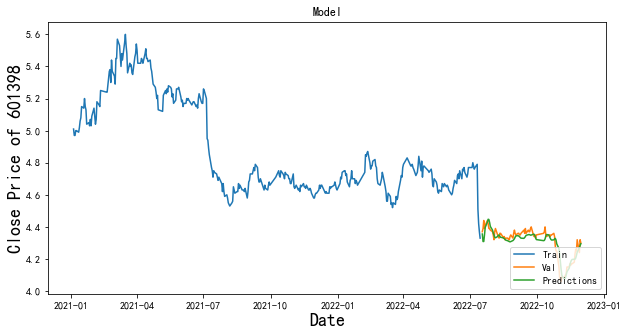

Epoch 1/100
10/10 [==============================] - 7s 256ms/step - loss: 0.0736 - val_loss: 881.3275
Epoch 2/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0207 - val_loss: 874.2350
Epoch 3/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0115 - val_loss: 880.1345
Epoch 4/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0108 - val_loss: 878.1966
Epoch 5/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0098 - val_loss: 877.6841
Epoch 6/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0102 - val_loss: 879.7300
Epoch 7/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0099 - val_loss: 879.4205
Epoch 8/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0079 - val_loss: 881.6048
Epoch 9/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0094 - val_loss: 877.7348
Epoch 10/100
10/10 [==============================] - 1s 106ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


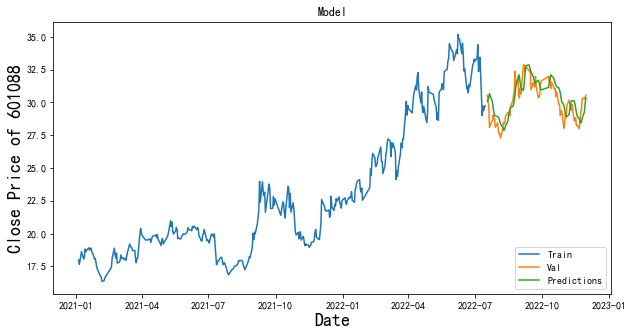

Epoch 1/100
10/10 [==============================] - 8s 234ms/step - loss: 0.0382 - val_loss: 6.9340
Epoch 2/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0129 - val_loss: 6.4723
Epoch 3/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0077 - val_loss: 6.7819
Epoch 4/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0054 - val_loss: 6.8225
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0052 - val_loss: 6.8884
Epoch 6/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0052 - val_loss: 6.9052
Epoch 7/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0050 - val_loss: 6.9323
Epoch 8/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0054 - val_loss: 6.9800
Epoch 9/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0050 - val_loss: 6.7807
Epoch 10/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0050 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


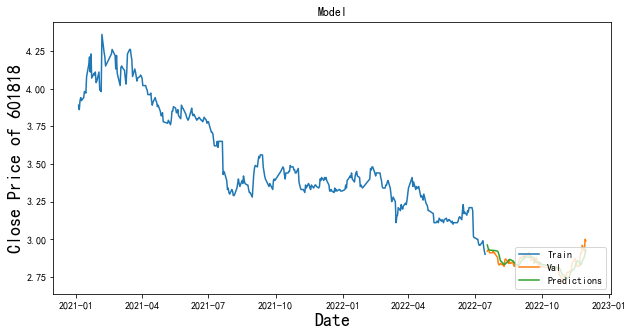

Epoch 1/100
10/10 [==============================] - 8s 240ms/step - loss: 0.1084 - val_loss: 18.6329
Epoch 2/100
10/10 [==============================] - 1s 127ms/step - loss: 0.0401 - val_loss: 18.0989
Epoch 3/100
10/10 [==============================] - 1s 139ms/step - loss: 0.0305 - val_loss: 18.4963
Epoch 4/100
10/10 [==============================] - 1s 138ms/step - loss: 0.0239 - val_loss: 18.3365
Epoch 5/100
10/10 [==============================] - 1s 131ms/step - loss: 0.0229 - val_loss: 18.8155
Epoch 6/100
10/10 [==============================] - 1s 139ms/step - loss: 0.0211 - val_loss: 18.7071
Epoch 7/100
10/10 [==============================] - 1s 121ms/step - loss: 0.0216 - val_loss: 18.7997
Epoch 8/100
10/10 [==============================] - 1s 126ms/step - loss: 0.0192 - val_loss: 19.1942
Epoch 9/100
10/10 [==============================] - 1s 133ms/step - loss: 0.0186 - val_loss: 19.0294
Epoch 10/100
10/10 [==============================] - 1s 134ms/step - loss: 0.0164

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


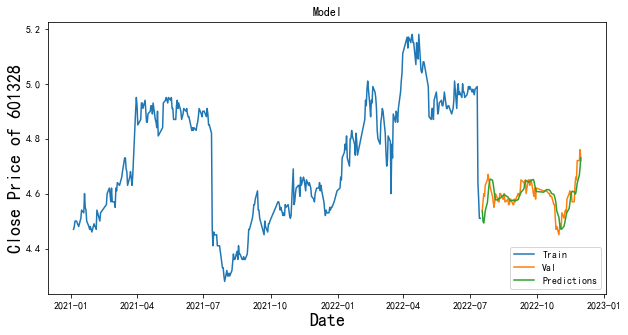

Epoch 1/100
10/10 [==============================] - 8s 231ms/step - loss: 0.0884 - val_loss: 7.9522
Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0387 - val_loss: 7.5761
Epoch 3/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0280 - val_loss: 7.8665
Epoch 4/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0246 - val_loss: 7.8099
Epoch 5/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0225 - val_loss: 7.9413
Epoch 6/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0211 - val_loss: 8.1084
Epoch 7/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0229 - val_loss: 8.2151
Epoch 8/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0230 - val_loss: 7.9304
Epoch 9/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0171 - val_loss: 8.0204
Epoch 10/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0197 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


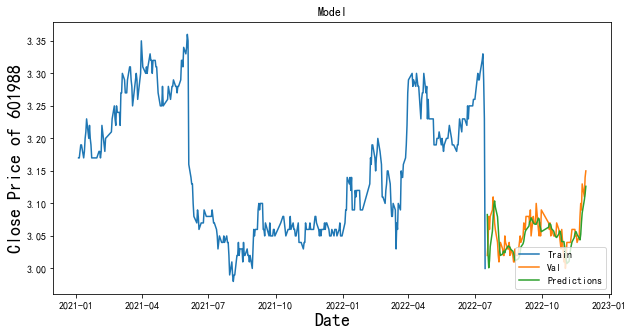

Epoch 1/100
10/10 [==============================] - 7s 225ms/step - loss: 0.0339 - val_loss: 27.7243
Epoch 2/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0152 - val_loss: 26.0936
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0107 - val_loss: 27.5140
Epoch 4/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0092 - val_loss: 26.6241
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0098 - val_loss: 27.0500
Epoch 6/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0080 - val_loss: 27.3978
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0080 - val_loss: 27.2322
Epoch 8/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0076 - val_loss: 27.0161
Epoch 9/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0067 - val_loss: 27.4550
Epoch 10/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0064

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


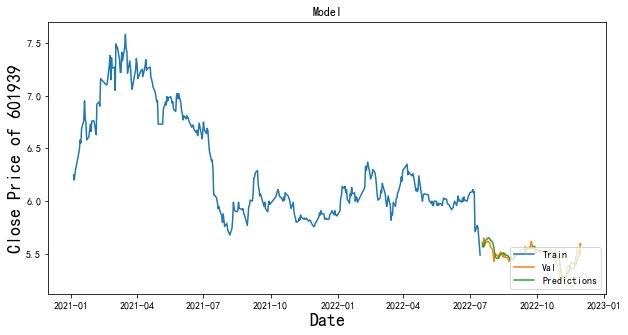

Epoch 1/100
10/10 [==============================] - 8s 232ms/step - loss: 0.0590 - val_loss: 6.2207
Epoch 2/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0163 - val_loss: 5.8946
Epoch 3/100
10/10 [==============================] - 1s 118ms/step - loss: 0.0117 - val_loss: 6.2753
Epoch 4/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0097 - val_loss: 6.1356
Epoch 5/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0087 - val_loss: 6.2050
Epoch 6/100
10/10 [==============================] - 1s 118ms/step - loss: 0.0084 - val_loss: 6.3264
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0082 - val_loss: 6.2943
Epoch 8/100
10/10 [==============================] - 1s 116ms/step - loss: 0.0094 - val_loss: 6.2771
Epoch 9/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0110 - val_loss: 6.1346
Epoch 10/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0088 - val_lo

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1069420191.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions8


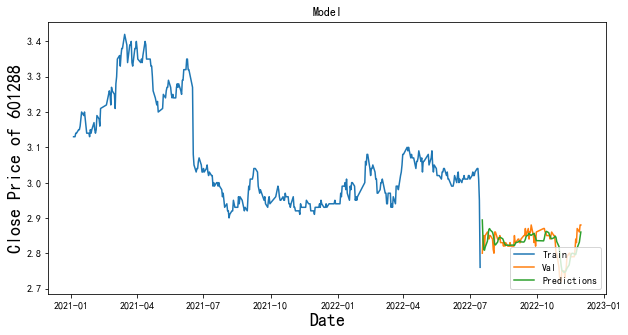

In [64]:
for i in SH50_cluster8_dic:
    data=SH50_cluster8_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster8_list = list(SH50_cluster8_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions8 = model.predict(x_test)

    predictions8 = scaler.inverse_transform(predictions8)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions8
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [65]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions8)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 99.10%


In [66]:
# Flatten predictions array
predictions8_flat = predictions8.flatten()

# Calculate global variance
global_variances = np.var(predictions8_flat) * ((len(predictions8_flat) )/( len(predictions8_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 0.0009198467052736125


In [67]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions8)-1):
    predicted_returns.append((predictions8[i+1]/predictions8[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: -0.01%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\1242621245.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [68]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions8, axis=0) / predictions8[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -0.5567017558296289


In [69]:
SH50_cluster9_dic = {}
for i in Cluster9:
    SH50_cluster9_dic [i]= ak.stock_zh_a_hist(symbol=i, period='daily', start_date="20210101", end_date='20221130', adjust="")

In [70]:
list_date = []
list_close=[]
for key in SH50_cluster9_dic.keys():
    SH50_cluster9_dic[key]['Date'] = SH50_cluster9_dic[key].pop('日期')
    SH50_cluster9_dic[key]['Close'] = SH50_cluster9_dic[key].pop('收盘')

Epoch 1/100
10/10 [==============================] - 8s 231ms/step - loss: 0.0474 - val_loss: 20.7447
Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0213 - val_loss: 19.1849
Epoch 3/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0153 - val_loss: 20.3186
Epoch 4/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0125 - val_loss: 19.1633
Epoch 5/100
10/10 [==============================] - 1s 116ms/step - loss: 0.0097 - val_loss: 19.6377
Epoch 6/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0084 - val_loss: 19.7467
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0084 - val_loss: 19.5171
Epoch 8/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0079 - val_loss: 19.5517
Epoch 9/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0087 - val_loss: 19.5464
Epoch 10/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0076

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


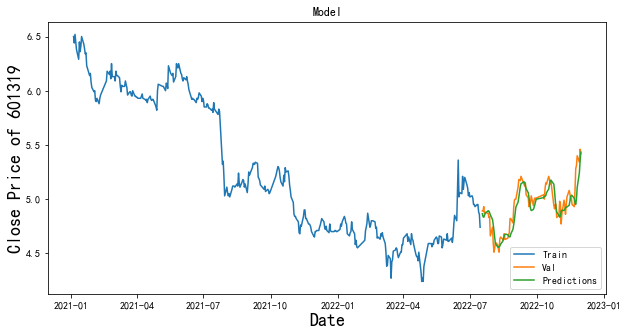

Epoch 1/100
10/10 [==============================] - 8s 226ms/step - loss: 0.0589 - val_loss: 739.1354
Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0173 - val_loss: 732.8850
Epoch 3/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0123 - val_loss: 740.4054
Epoch 4/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0102 - val_loss: 734.5549
Epoch 5/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0078 - val_loss: 738.4953
Epoch 6/100
10/10 [==============================] - 1s 116ms/step - loss: 0.0065 - val_loss: 738.9631
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 0.0061 - val_loss: 737.5987
Epoch 8/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0068 - val_loss: 737.9501
Epoch 9/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0070 - val_loss: 738.0317
Epoch 10/100
10/10 [==============================] - 1s 117ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


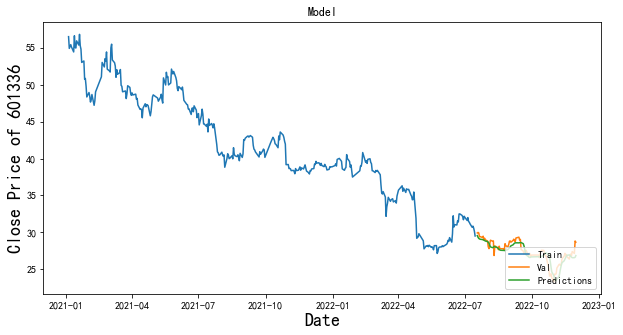

Epoch 1/100
10/10 [==============================] - 9s 263ms/step - loss: 0.0503 - val_loss: 21.0144
Epoch 2/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0193 - val_loss: 19.5547
Epoch 3/100
10/10 [==============================] - 1s 118ms/step - loss: 0.0166 - val_loss: 20.4472
Epoch 4/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0135 - val_loss: 20.3073
Epoch 5/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0120 - val_loss: 20.2412
Epoch 6/100
10/10 [==============================] - 1s 121ms/step - loss: 0.0134 - val_loss: 19.7699
Epoch 7/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0139 - val_loss: 20.8416
Epoch 8/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0135 - val_loss: 20.5285
Epoch 9/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0124 - val_loss: 20.0226
Epoch 10/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0124

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


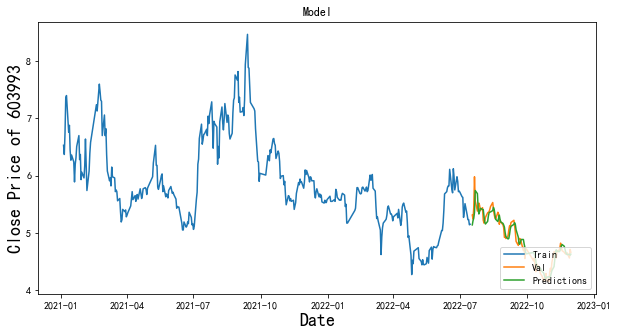

Epoch 1/100
10/10 [==============================] - 8s 271ms/step - loss: 0.0306 - val_loss: 417.1989
Epoch 2/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0067 - val_loss: 413.6196
Epoch 3/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0055 - val_loss: 417.0123
Epoch 4/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0035 - val_loss: 415.0019
Epoch 5/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0036 - val_loss: 414.0968
Epoch 6/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0034 - val_loss: 416.5904
Epoch 7/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0031 - val_loss: 416.2373
Epoch 8/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0038 - val_loss: 415.1696
Epoch 9/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0032 - val_loss: 414.6049
Epoch 10/100
10/10 [==============================] - 1s 103ms/step - los

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


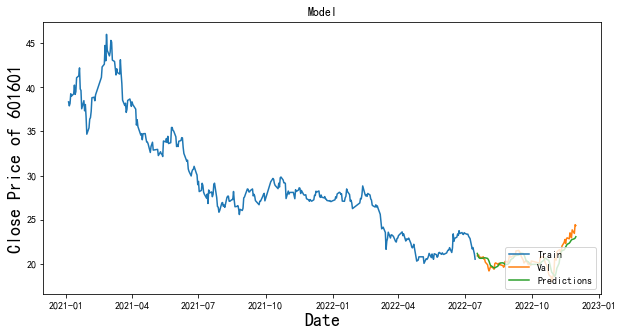

Epoch 1/100
10/10 [==============================] - 8s 222ms/step - loss: 0.0620 - val_loss: 7512.0830
Epoch 2/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0134 - val_loss: 7521.3403
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0095 - val_loss: 7526.7480
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0085 - val_loss: 7512.0952
Epoch 5/100
10/10 [==============================] - 1s 101ms/step - loss: 0.0088 - val_loss: 7508.9727
Epoch 6/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0070 - val_loss: 7524.3784
Epoch 7/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0082 - val_loss: 7517.0693
Epoch 8/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0080 - val_loss: 7502.5000
Epoch 9/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0077 - val_loss: 7515.0664
Epoch 10/100
10/10 [==============================] - 1s 101ms/s

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


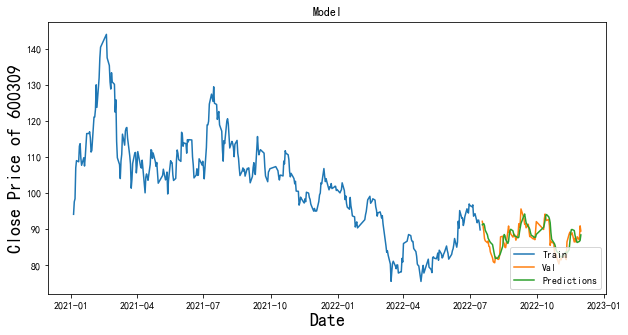

Epoch 1/100
10/10 [==============================] - 8s 217ms/step - loss: 0.0380 - val_loss: 868.3812
Epoch 2/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0148 - val_loss: 862.3853
Epoch 3/100
10/10 [==============================] - 1s 102ms/step - loss: 0.0114 - val_loss: 862.9399
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 0.0099 - val_loss: 864.0303
Epoch 5/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0093 - val_loss: 863.9662
Epoch 6/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0084 - val_loss: 859.5270
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0077 - val_loss: 861.3431
Epoch 8/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0067 - val_loss: 861.9189
Epoch 9/100
10/10 [==============================] - 1s 103ms/step - loss: 0.0077 - val_loss: 861.7476
Epoch 10/100
10/10 [==============================] - 1s 105ms/step - loss

C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2384751081.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions9


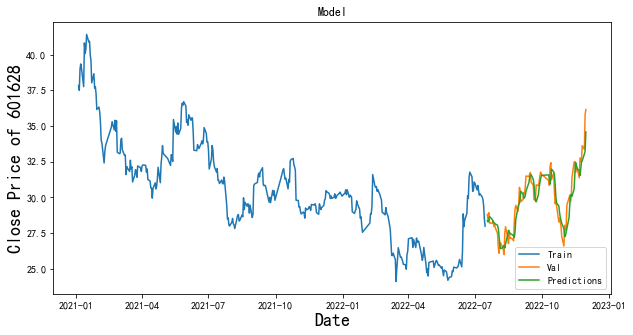

In [71]:
for i in SH50_cluster9_dic:
    data=SH50_cluster9_dic[i]
    df = pd.DataFrame(data, columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
    dataset=data[['Close']].values
    Cluster9_list = list(SH50_cluster9_dic)

#取80%的数据作为训练集
    training_data_len=math.ceil(len(dataset)*.8)
    train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
    test_data = dataset[training_data_len-60: , : ]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_train=scaler.fit_transform(train_data)
    scaled_test=scaler.fit_transform(test_data)
    #训练集的重构
    #1 分离x和y
    x_train=[]
    y_train=[]
    for t in range(60,len(scaled_train)):
        x_train.append(scaled_train[t-60:t,0])
        y_train.append(scaled_train[t,0])
    #2 将list类型数据转变成array数据
    x_train,y_train=np.array(x_train),np.array(y_train)
    #3 将二维数据变成三维数据
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    #测试集的重构
    #1 分离x和y
    x_test = []
    y_test = dataset[training_data_len: , : ]
    for t in range(60,len(scaled_test)):
        x_test.append(scaled_test[t-60:t,0])
    #2 将list类型数据转变成array数据
    x_test = np.array(x_test)
    #3 将二维数据变成三维数据
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #Build model
    #Initialize model
    # Initialize model
    model = Sequential()

    # Add first LSTM layer with 100 units and input shape of (60, 1)
    model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(.2))

    # Add second LSTM layer with 50 units
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(.2))

    # Add third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(.2))

    # Add fully connected layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model with more epochs and a smaller batch size
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        validation_freq=1)

    # Make predictions
    predictions9 = model.predict(x_test)

    predictions9 = scaler.inverse_transform(predictions9)
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #给valid添加新的一列，把预测值predictions赋值给新的一列
    valid['Predictions'] = predictions9
    #开始作图
    #图像大小
    plt.figure(figsize=(10,5))
    #图像标题
    plt.plot(train['Close'])
    #分别画出真实值和预测值的折线图
    plt.plot(valid[['Close', 'Predictions']])
    plt.title('Model')
    #x轴
    plt.xlabel('Date', fontsize=18)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #y轴
    #画训练集的折线图
    plt.ylabel('Close Price of '+ str(i), fontsize=18)
    #展示图例
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [72]:
# Calculate root mean squared error (RMSE)
mse = mean_squared_error(y_test, predictions9)
rmse = math.sqrt(mse)

# Calculate the percentage of prediction accuracy
accuracy = (1 - rmse / np.mean(y_test)) * 100
print(f"Percentage of prediction accuracy: {accuracy:.2f}%")

Percentage of prediction accuracy: 97.31%


In [73]:
# Flatten predictions array
predictions9_flat = predictions9.flatten()

# Calculate global variance
global_variances = np.var(predictions9_flat) * ((len(predictions9_flat) )/( len(predictions9_flat)- 1))

print("Global Variance:", global_variances)

Global Variance: 3.60051884493985


In [74]:
# Calculate predicted returns of test data
predicted_returns = []
for i in range(len(predictions9)-1):
    predicted_returns.append((predictions9[i+1]/predictions9[i])-1)

# Calculate expected return
expected_return = sum(predicted_returns) / len(predicted_returns)

print("Expected return: {:.2%}".format(np.asscalar(expected_return)))

Expected return: 0.23%


C:\Users\93058\AppData\Local\Temp\ipykernel_15492\2117300001.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Expected return: {:.2%}".format(np.asscalar(expected_return)))


In [75]:
# Calculate daily returns from predicted closing prices
predicted_returns = np.diff(predictions9, axis=0) / predictions9[:-1]

# Calculate daily average return and standard deviation
daily_returns_mean = np.mean(predicted_returns)
daily_returns_std = np.std(predicted_returns)

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns_mean / daily_returns_std) * np.sqrt(252)

print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  2.5929480650960124
